In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import meshio
from pathlib import Path


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

import os

from triangular_transport.flows.flow_trainer import (
    NNTrainer,
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import vec_field_loss
from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler

import json
import h5py

import argparse

plt.style.use("ggplot")

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update("jax_default_device", jax.devices()[1])

In [2]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [29]:
with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state_grid.npy")
map_est = np.load("training_dataset/map_param_grid.npy")
targets, yobs = read_data_h5()

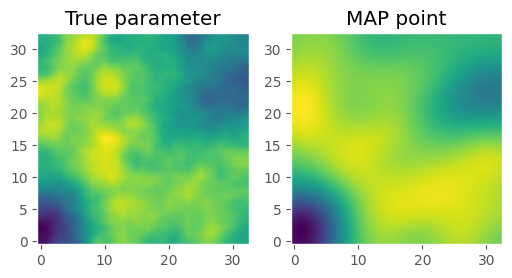

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(6,6))

ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True parameter")
ax[0].grid(False)

ax[1].imshow(map_est, origin="lower", interpolation="bilinear")
ax[1].set_title("MAP point")
ax[1].grid(False)

In [5]:
nsamples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]

hmala_samps = np.load("training_dataset/chain_30/hmala_samples_grid_delta.npy").reshape(nsamples, 33, 33)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

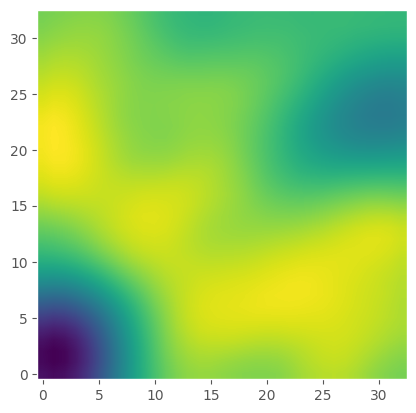

In [7]:
plt.imshow(hmala_mean, origin="lower", interpolation="bilinear")
plt.grid(False)

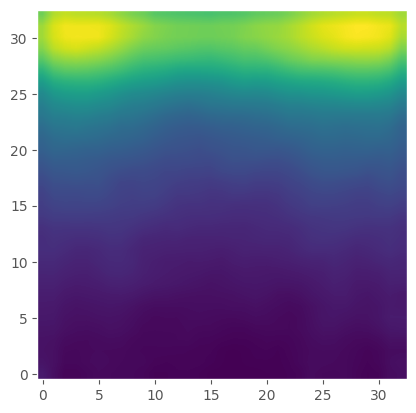

In [8]:
plt.imshow(hmala_var, origin="lower", interpolation="bilinear")
plt.grid(False)

In [10]:
train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid_delta.npy"))[:train_dim]
us = (np.load("training_dataset/parameters_delta.npy"))[:train_dim, :].reshape(train_dim, flat_length)

us_ref = us.copy()
np.random.shuffle(us_ref)

us_test = (np.load("training_dataset/parameters_delta.npy"))[train_dim:train_dim + 20000, :].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

In [11]:
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [12]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

target_data = jnp.hstack([ys_normalized, us_pca])
ref_data = jnp.hstack([ys_normalized, us_ref_pca])

In [18]:
key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 128
steps = 50000
print_every = 5000
yu_dimension = (100, k.item())
dim = yu_dimension[0] + yu_dimension[1]
hidden_layer_list = [512] * 4
model = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.gelu,  # GeLU worked well
)
schedule = optax.linear_schedule(
    init_value=1e-3,          # Starting learning rate
    end_value=3e-4,           # Final learning rate
    transition_steps=2000     # Number of steps over which to linearly increase
)
# schedule = optax.warmup_cosine_decay_schedule(
#     init_value=0.0,
#     peak_value=3e-4,
#     warmup_steps=2_000,
#     decay_steps=steps,
#     end_value=1e-5,
# )
# lr=1e-9
optimizer = optax.adamw(schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

In [19]:
trainer = NNTrainer(
    target_density=None,
    model=model,
    optimizer=optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=vec_field_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    train_data=target_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=ref_data,
);

Training neural network


  0%|          | 0/50000 [00:00<?, ?it/s]

step = 0, train_loss = 0.132947638630867
step = 5000, train_loss = -57.71990966796875
step = 10000, train_loss = -59.545433044433594
step = 15000, train_loss = -64.46372985839844
step = 20000, train_loss = -65.98764038085938
step = 25000, train_loss = -64.37849426269531
step = 30000, train_loss = -67.84879302978516
step = 35000, train_loss = -66.84800720214844
step = 40000, train_loss = -67.4301528930664
step = 45000, train_loss = -64.89543151855469
step = 49999, train_loss = -67.64894104003906


In [20]:
no_samples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
ytrue_flat = yobs.copy()
ytrue_flat_normalized = ys_normalizer.encode(ytrue_flat)
ys_test_normalized = jnp.full(
    (no_samples, ytrue_flat_normalized.shape[0]), ytrue_flat_normalized
)
x0_test = jnp.hstack([ys_test_normalized, us_test_pca])
# x0_test = jnp.hstack([ys_test_normalized, us_test])

cond_values = [tuple(ytrue_flat_normalized)]
cond_samples = trainer.conditional_sample(
    cond_values=cond_values, x0_cond=x0_test, nsamples=20000
)
all_samples = cond_samples[0][0]

u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(no_samples, nx, ny)
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

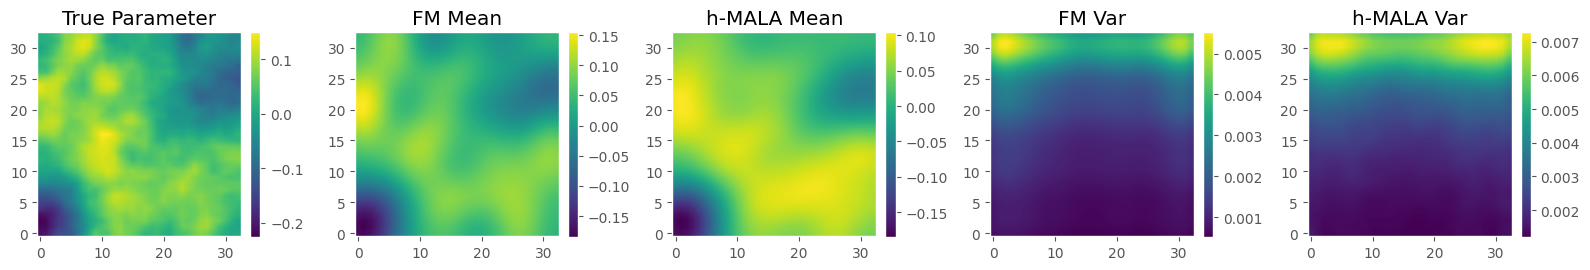

In [21]:
layer_idx = 0
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

im0 = ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True Parameter")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("FM Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(
    hmala_mean, origin="lower", interpolation="bilinear"
)
ax[2].set_title("h-MALA Mean")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(u_var, origin="lower", interpolation="bilinear")
ax[3].set_title("FM Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

im4 = ax[4].imshow(hmala_var, origin="lower", interpolation="bilinear")
ax[4].set_title("h-MALA Var")
ax[4].grid(False)
fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

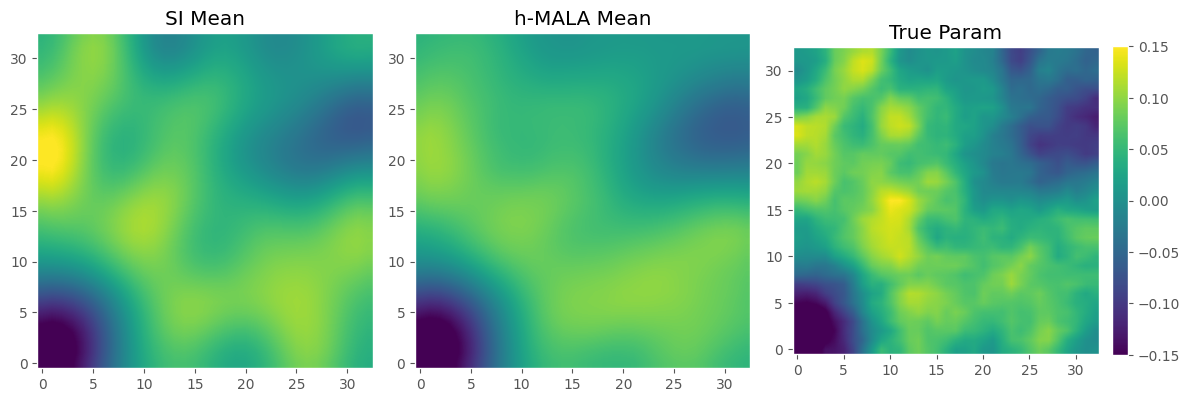

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12,12))
vmin, vmax = -0.15, 0.15

im1 = ax[0].imshow(u_means, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="bilinear", origin="lower")
ax[0].grid(False)
ax[0].set_title("SI Mean")
im2 = ax[1].imshow(hmala_mean, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="bilinear", origin="lower")
ax[1].grid(False)
ax[1].set_title("h-MALA Mean")
im3 = ax[2].imshow(utrue, cmap="viridis", vmin=vmin, vmax=vmax, interpolation="bilinear", origin="lower")
ax[2].grid(False)
ax[2].set_title("True Param")
fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()

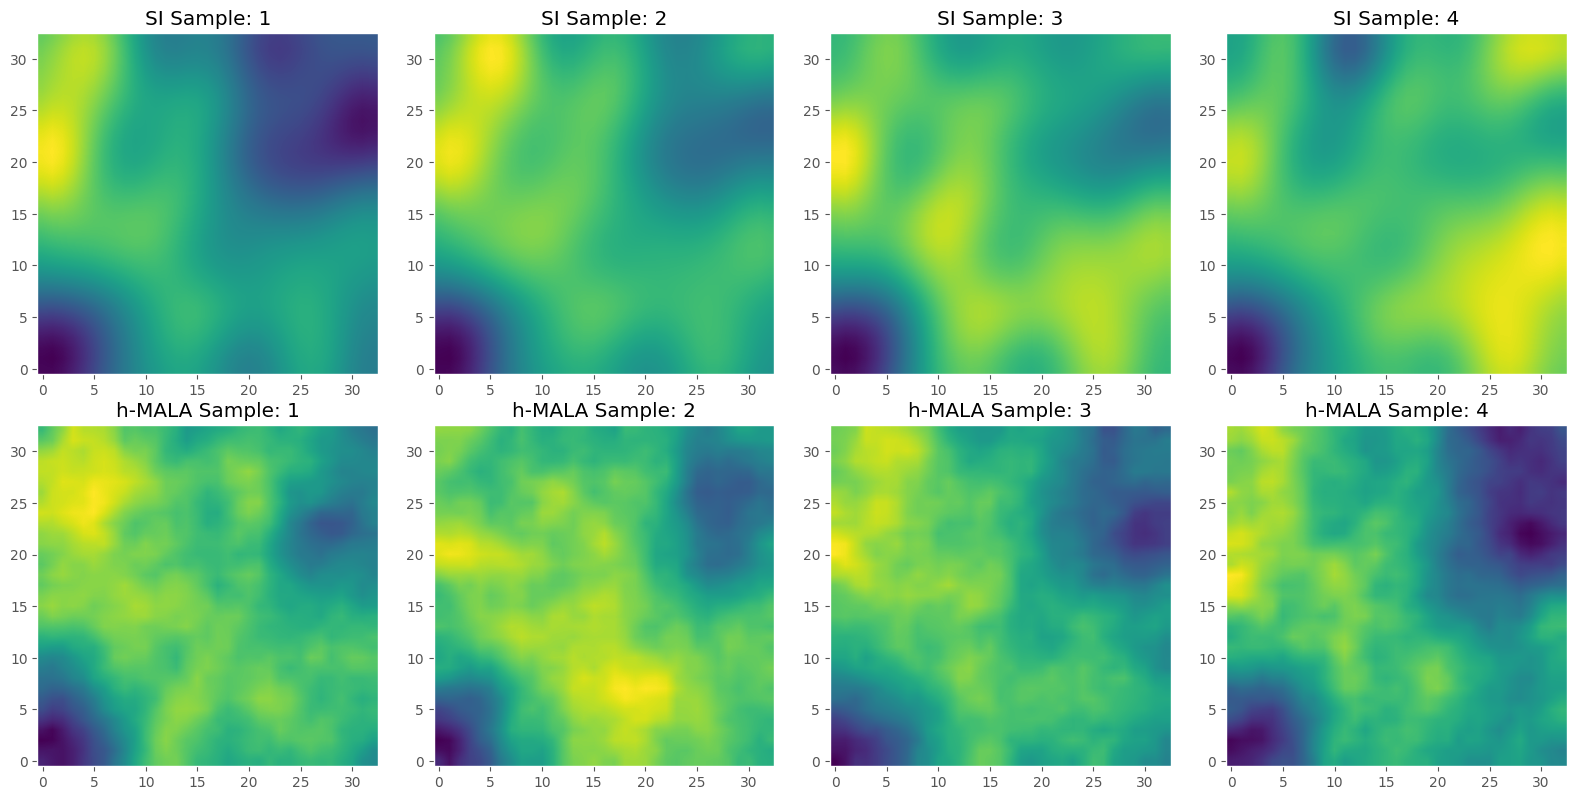

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for i in range(len(ax)):
    if i == 0:
        for j in range(len(ax[i])):
            ax[i][j].imshow(u_samples[np.random.choice(u_samples.shape[0]), :, :], origin="lower", interpolation="bilinear")
            ax[i][j].set_title(f"SI Sample: {j+1}")
            ax[i][j].grid(False)
    else:
        for j in range(len(ax[i])):
            ax[i][j].imshow(hmala_samps[np.random.choice(hmala_samps.shape[0]), :, :], origin="lower", interpolation="bilinear")
            ax[i][j].set_title(f"h-MALA Sample: {j+1}")
            ax[i][j].grid(False)
plt.tight_layout()